In [1]:
import sys
sys.path.append('..')

from scripts.autoencoders import InMemoryImageDataset, split_images, ConfigurableAutoencoder
from scripts.measuring_quality import second_order_method

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from omegaconf import OmegaConf
import warnings
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import random

In [2]:
try:
    OmegaConf.register_new_resolver("eval", eval)
except ValueError:
    pass

Elegir el archivo de configuración correspondiente:

In [3]:
config_name = 'config_3' # Elegir

config_path = f'configs/imagenes_reales/{config_name}.yaml'
config = OmegaConf.load(config_path)
config

{'training': {'num_epochs': 200, 'batch_size': 64, 'learning_rate': 0.001, 'scheduler_name': 'elr', 'scheduler_params': {'gamma': 0.97}, 'side_size': 256}, 'model': {'encoding_dim': 1500, 'loss_function': 'mse', 'optimizer': 'adam'}, 'encoder': {'layers': [{'type': 'conv2d', 'filters': 4, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': 'relu'}, {'type': 'conv2d', 'filters': 4, 'kernel_size': 4, 'stride': 2, 'padding': 1, 'activation': 'relu'}, {'type': 'conv2d', 'filters': 8, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': 'relu'}, {'type': 'conv2d', 'filters': 16, 'kernel_size': 4, 'stride': 2, 'padding': 1, 'activation': 'relu'}, {'type': 'conv2d', 'filters': 32, 'kernel_size': 4, 'stride': 2, 'padding': 1, 'activation': 'relu'}, {'type': 'conv2d', 'filters': 64, 'kernel_size': 4, 'stride': 2, 'padding': 1, 'activation': 'relu'}]}, 'decoder': {'layers': [{'type': 'conv2d_transpose', 'filters': 32, 'kernel_size': 4, 'stride': 2, 'padding': 1, 'in_channels': 64, '

Cargo el autoencoder ya entrenado:

In [4]:
image_size = config['training']['side_size']

In [5]:
# 1. Crear una instancia del modelo (debe tener la misma arquitectura)
autoencoder_cargado = ConfigurableAutoencoder(config=config, image_size=image_size)
# 2. Carga los parámetros
autoencoder_cargado.load_state_dict(torch.load(f'data/trained_models/imagenes_reales/{config_name}.pth'))
# 3. Modo evaluación (cuando lo use para inferencia)
autoencoder_cargado.eval()

ConfigurableAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(4, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(8, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

Genero dataset de testeo:

In [6]:
def load_tiff_datasets(carpeta):
    carpeta_archivos = f"C:/Users/Bianca/Documents/Archivos/ITBA/Tesis_Maestria/SAR_despeckling_filters_dataset/Main_folder/{carpeta}/"
    archivos_tiff = [f for f in os.listdir(carpeta_archivos) if f.endswith('.tiff')]

    num_imagenes = len(archivos_tiff)
    array_final = np.empty((num_imagenes, 512, 512), dtype=np.uint8)

    for i, archivo in enumerate(archivos_tiff):
        imagen = Image.open(os.path.join(carpeta_archivos, archivo))
        array_imagen = np.array(imagen)[:, :, 0]
        array_final[i] = array_imagen
        
        if (i+1) % 250 == 0:
            print(f'{i+1} de {num_imagenes} imágenes procesadas')

    print(f'\nArray final shape: {array_final.shape}')
    print(f'Máximo valor: {array_final.max()}, mínimo valor: {array_final.min()}')
    
    return array_final

In [7]:
noisy_val = load_tiff_datasets('Noisy_val')


Array final shape: (100, 512, 512)
Máximo valor: 255, mínimo valor: 0


In [8]:
clean_val = load_tiff_datasets('GTruth_val')


Array final shape: (100, 512, 512)
Máximo valor: 255, mínimo valor: 0


In [9]:
clean_val = clean_val[np.array([np.min(img) != np.max(img) for img in clean_val])]
noisy_val = noisy_val[np.array([np.min(img) != np.max(img) for img in noisy_val])]
print(clean_val.shape)
print(noisy_val.shape)

(100, 512, 512)
(100, 512, 512)


In [10]:
autoencoder_cargado.eval() # Para desactivar Dropout, BatchNorm, etc.
batch_size = config['testing']['batch_size']

In [11]:
if config['training']['side_size'] == 512:
    pass

else:
    clean_val = split_images(clean_val, config['training']['side_size'])
    noisy_val = split_images(noisy_val, config['training']['side_size'])    
    
    clean_val = clean_val[np.array([np.min(img) != np.max(img) for img in clean_val])]
    noisy_val = noisy_val[np.array([np.min(img) != np.max(img) for img in noisy_val])]
    
print(clean_val.shape)
print(noisy_val.shape)

(396, 256, 256)
(396, 256, 256)


In [12]:
normalize_to_01 = transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))

transform = transforms.Compose([
    transforms.ToTensor(),
    normalize_to_01
])

dataset_test = InMemoryImageDataset(noisy_val, clean_val, transform=transform)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

Gráficos de ratios

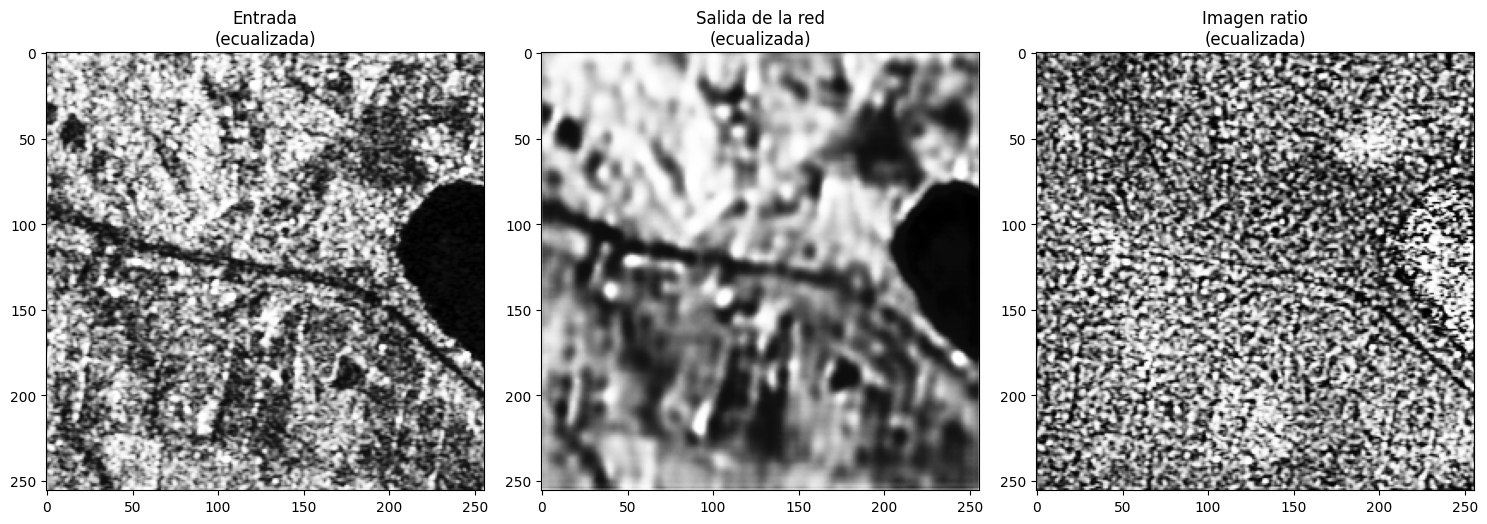

In [13]:
# Aplico el autoencoder a un ejemplo particular del dataset de testeo y veo cómo queda la
# imagen de salida + la imagen ratio.

ecualizar_hist = True  # Si se quiere o no ecualizar el histograma de la imagen

###

def graph_random_image(ecualizar_hist, name_suffix, show_plot=True):

    index = int(noisy_val.shape[0]*np.random.random()) # Índice del ejemplo puntual que se desea seleccionar
    entrada_red, salida_red = dataset_test[index]

    example = entrada_red.float().unsqueeze(0)

    reconstructed = autoencoder_cargado(example) # Aplica el autoencoder al ejemplo

    tamanio = noisy_val.shape[1]

    entrada = entrada_red.view(tamanio, tamanio)
    salida_esperada = salida_red.view(tamanio, tamanio)
    reconstructed = reconstructed.view(tamanio, tamanio)
    ratio = entrada / reconstructed.detach()

    imagenes = [entrada, reconstructed.detach(), ratio]
    titulos = ['Entrada', 'Salida de la red', 'Imagen ratio']

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for ax, imagen, titulo in zip(axes, imagenes, titulos):
        if ecualizar_hist:
            im = imagen.cpu().numpy()
            im = ((im - im.min()) * 255) / (im.max() - im.min())
            imagen = cv2.equalizeHist(im.astype(np.uint8))
            titulo += '\n(ecualizada)'
        
        ax.imshow(imagen, cmap='gray')
        ax.set_title(titulo)

    plt.tight_layout()

    return imagenes, titulos

imagenes, titulos = graph_random_image(ecualizar_hist=ecualizar_hist, name_suffix=1, show_plot=True)

---

Calculo las imágenes ratio bien para poder tenerlas en una variable.

In [14]:
all_inputs = []
all_targets = []
all_outputs = []
all_ratios = []

with torch.no_grad():
    for entrada, salida in test_loader:
        entrada = entrada.float()
        salida = salida.float()
        outputs = autoencoder_cargado(entrada)
        ratios = entrada / outputs
        
        all_inputs.append(entrada.cpu().numpy())
        all_targets.append(salida.cpu().numpy())
        all_outputs.append(outputs.cpu().numpy())
        all_ratios.append(ratios.cpu().numpy())

inputs = np.squeeze(np.concatenate(all_inputs, axis=0))
targets = np.squeeze(np.concatenate(all_targets, axis=0))
outputs = np.squeeze(np.concatenate(all_outputs, axis=0))
ratios = np.squeeze(np.concatenate(all_ratios, axis=0))

## Método de primer orden

Como son imágenes reales, va a haber que tomar las zonas homogéneas a mano, tomando zonas que sean las más oscuras. Lo haré con un par de imágenes nomás.

Imagen: 89


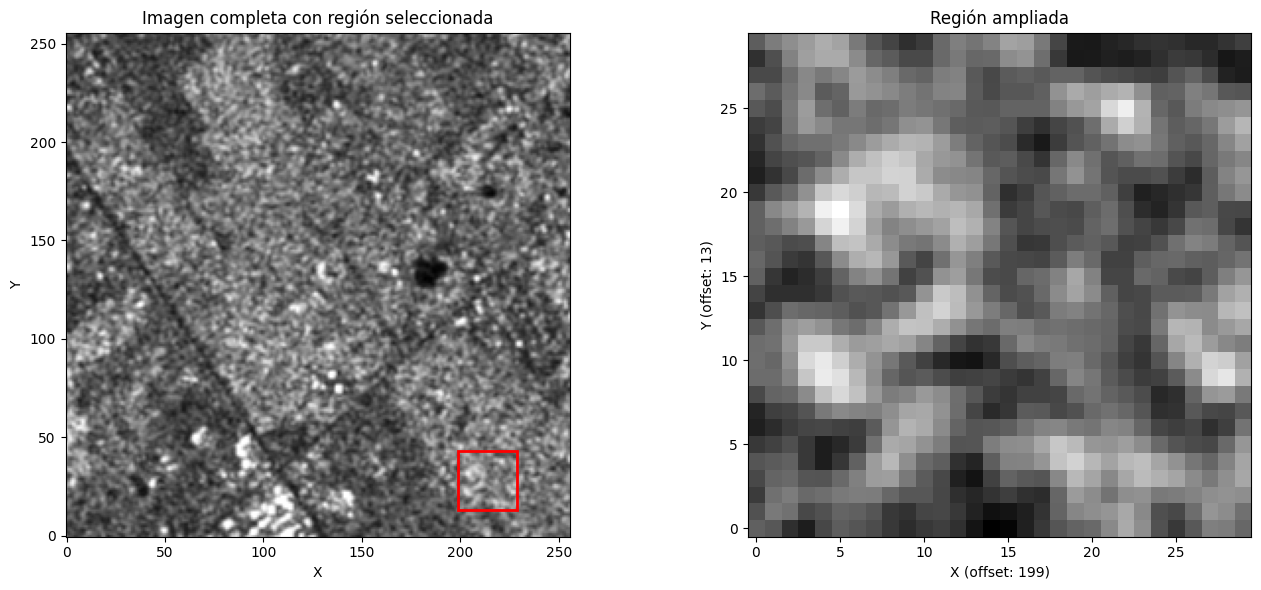

In [15]:
indice = random.randint(0, inputs.shape[0] - 1)
#indice = 4
print(f'Imagen: {indice}')

df =  inputs[indice]

# Definir puntos del cuadrado
xi, yi = 199, 13
xf, yf = xi+30, yi+30

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.imshow(df, cmap='gray', origin='lower')
rect = patches.Rectangle((xi, yi), xf-xi, yf-yi, 
                         linewidth=2, edgecolor='red', facecolor='none')
ax1.add_patch(rect)
ax1.set_title('Imagen completa con región seleccionada')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

region = df[yi:yf, xi:xf]
ax2.imshow(region, cmap='gray', origin='lower')
ax2.set_title('Región ampliada')
ax2.set_xlabel(f'X (offset: {xi})')
ax2.set_ylabel(f'Y (offset: {yi})')

plt.tight_layout()

In [16]:
# Guardo manualmente las imágenes que voy a usar para calcular el estadístico, y las coordenadas de las
# zonas homogéneas (voy a tomar zonas oscuras) de esas imágenes. Y esto para cada uno de los configs.

zonas_hom = {
    'config_1': {
        'indices_im': [4, 4, 4, 40, 40, 40, 12, 12, 12],
        'cuads_i': [(300, 150), (70, 60), (390, 25), (390, 25), (250, 10), (39, 31), (39, 31), (250, 10), (450, 21)]
    },
    'config_2': {
        'indices_im': [12, 12, 12, 299, 299, 299, 122, 122, 122],
        'cuads_i': [(190, 1), (220, 35), (224, 95), (210, 23), (100, 30), (10, 34), (13, 39), (139, 90), (198, 170)]
    },
    'config_3': {
        'indices_im': [376, 376, 376, 323, 323, 323, 257, 257, 257],
        'cuads_i': [(198, 200), (99, 190), (16, 210), (16, 10), (113, 21), (214, 61), (204, 8), (125, 28), (15, 48)]
    },
    'config_4': {
        'indices_im': [1046, 1046, 1046, 169, 169, 169, 891, 891, 891],
        'cuads_i': [(15, 48), (40, 45), (89, 12), (89, 89), (55, 80), (5, 75), (5, 75), (60, 50), (89, 83)]
    },
    'config_5': {
        'indices_im': [118, 118, 118, 170, 170, 170, 4, 4, 4],
        'cuads_i': [(89, 83), (5, 5), (200, 120), (200, 110), (125, 76), (11, 49), (11, 7), (111, 8), (199, 13)]
    }
}

In [17]:
for config in zonas_hom:
    zonas_hom[config]['cuads_f'] = [(x + 30, y + 30) for x, y in zonas_hom[config]['cuads_i']]

zonas_hom

{'config_1': {'indices_im': [4, 4, 4, 40, 40, 40, 12, 12, 12],
  'cuads_i': [(300, 150),
   (70, 60),
   (390, 25),
   (390, 25),
   (250, 10),
   (39, 31),
   (39, 31),
   (250, 10),
   (450, 21)],
  'cuads_f': [(330, 180),
   (100, 90),
   (420, 55),
   (420, 55),
   (280, 40),
   (69, 61),
   (69, 61),
   (280, 40),
   (480, 51)]},
 'config_2': {'indices_im': [12, 12, 12, 299, 299, 299, 122, 122, 122],
  'cuads_i': [(190, 1),
   (220, 35),
   (224, 95),
   (210, 23),
   (100, 30),
   (10, 34),
   (13, 39),
   (139, 90),
   (198, 170)],
  'cuads_f': [(220, 31),
   (250, 65),
   (254, 125),
   (240, 53),
   (130, 60),
   (40, 64),
   (43, 69),
   (169, 120),
   (228, 200)]},
 'config_3': {'indices_im': [376, 376, 376, 323, 323, 323, 257, 257, 257],
  'cuads_i': [(198, 200),
   (99, 190),
   (16, 210),
   (16, 10),
   (113, 21),
   (214, 61),
   (204, 8),
   (125, 28),
   (15, 48)],
  'cuads_f': [(228, 230),
   (129, 220),
   (46, 240),
   (46, 40),
   (143, 51),
   (244, 91),
   (234,

In [18]:
n_imagenes = len(set(zonas_hom[config_name]['indices_im']))

r_ENL_mu_total = 0
for i in range(n_imagenes):

    cuads_i = zonas_hom[config_name]['cuads_i'][i*n_imagenes:i*n_imagenes+3]
    cuads_f = zonas_hom[config_name]['cuads_f'][i*n_imagenes:i*n_imagenes+3]
    original_image = inputs[zonas_hom[config_name]['indices_im'][i*n_imagenes]]
    ratio_image = ratios[zonas_hom[config_name]['indices_im'][i*n_imagenes]]

    suma = 0
    for j in range(len(cuads_i)):

        zona_o = original_image[cuads_i[j][0]:cuads_f[j][0], cuads_i[j][1]:cuads_f[j][1]]
        zona_r = ratio_image[cuads_i[j][0]:cuads_f[j][0], cuads_i[j][1]:cuads_f[j][1]]
        
        mu_o = zona_o.mean()
        mu_r = zona_r.mean()
        std_o = zona_o.std()
        std_r = zona_r.std()
        
        ENL_o = mu_o**2 / std_o**2
        ENL_r = mu_r**2 / std_r**2
        r_ENL = np.abs(ENL_o - ENL_r) / ENL_o
        r_mu = np.abs(1-mu_r)

        suma += r_ENL + r_mu

    r_ENL_mu = suma / (2*len(cuads_i))
    r_ENL_mu_total += r_ENL_mu

r_ENL_mu_promedio = r_ENL_mu_total / n_imagenes
r_ENL_mu_promedio

np.float32(0.3035737)

## Método de segundo orden

In [19]:
som = second_order_method(ratios, g=30)

Procesadas 0 imágenes de 396


El filtro perfecto produciría un estadístico de segundo orden igual a 0.

Media del estadístico de 2do orden sobre todas las imágenes: 30.721325308784458
Desviación estándar del estadístico de 2do orden sobre todas las imágenes: 7.423856346255581



Text(0.5, 1.0, 'Distribución del estadístico de 2do orden')

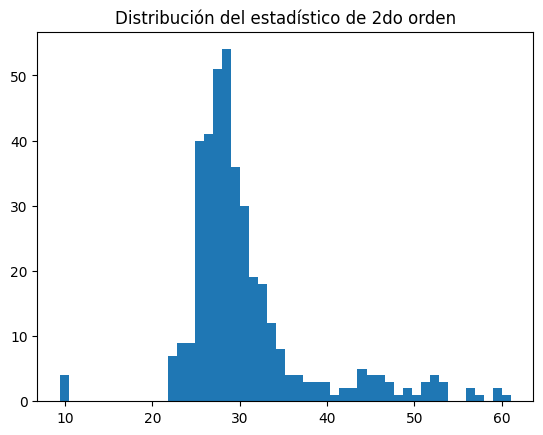

In [20]:
print(f'El filtro perfecto produciría un estadístico de segundo orden igual a 0.\n')
print(f'Media del estadístico de 2do orden sobre todas las imágenes: {np.mean(som)}')
print(f'Desviación estándar del estadístico de 2do orden sobre todas las imágenes: {np.std(som)}\n')
plt.hist(som, bins=50)
plt.title('Distribución del estadístico de 2do orden')